We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, is there a well-performing model that already exists for our problem?

And in the world of deep learning, the answer is often yes.

We'll see how by using a powerful technique called transfer learning.

### What is transfer learning?

* Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

* For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

* Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

<img src="tl.png" width="700" height="100">

### Why use transfer learning?
There are two main benefits to using transfer learning:

* Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
* Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

<img src="tl2.png" width="700" height="100">

* We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

### Where to find pretrained models
The world of deep learning is an amazing place.

So amazing that many people around the world share their work.

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

<img src="pretrainedmodels.png" width="500" height="100">

In [7]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1
torchvision version: 0.13.1


In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [9]:
# GET DATA
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [10]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### Creating a transform for torchvision.models (manual creation)
* When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.
* All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
* The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

* For normalization input[channel] = (input[channel] - mean[channel]) / std[channel], the mean and standard deviation values are to be taken from the training dataset.

* Here, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] are the mean and std of Imagenet dataset.

* orijinal veri kümesindeki (COCO veya PascalVOC gibi) renklerin dağılımı olabilir. Tüm renklerin eşit olarak temsil edilmesi sadece şans eseri olacaktır.

<img src="meanstd.png" height="100" width="400">
* Yani her pixel de normalleştirmek için rgb mantığında bu hesabı yapıyorum bunu yaparkende pretrain edilmiş Imagenet in std, mean i kullandım...

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Imagenet'in ortalamasını ve standartını kullanmak yaygın bir uygulamadır. 
# Milyonlarca görüntüye göre hesaplanırlar. Kendi veri kümeniz üzerinde sıfırdan eğitim yapmak istiyorsanız,
# yeni ortalamayı ve std'yi hesaplayabilirsiniz. 
# Aksi takdirde, Imagenet ön denemeli modelinin kendi ortalaması ve std'si ile kullanılması tavsiye edilir.

The good news is, we can achieve the above transformations with a combination of:
<img src="transforms.png" width="500" height="100">

In [15]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Wonderful!

Now we've got a manually created series of transforms ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the create_dataloaders function from the data_setup.py script we created in 05. PyTorch Going Modular Part 2.

We'll set batch_size=32 so our model see's mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting transform=simple_transform.

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15ee69690>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for torchvision.models (auto creation)

* As previously stated, when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

* Above we saw how to manually create a transform for a pretrained model.

* But as of torchvision v0.13+, an automatic transform creation feature has been added.

* When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`

* EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many differnt model architecture options in torchvision.models).
* DEFAULT means the best available weights (the best performance in ImageNet).
* Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option. See the torchvision.models documentation for more.

In [17]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


* Notice how auto_transforms is very similar to manual_transforms, the only difference is that auto_transforms came with the model architecture we chose, where as we had to create manual_transforms by hand.

* The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

* However, the tradeoff of using automatically created transforms is a lack of customization.

* We can use auto_transforms to create DataLoaders with create_dataloaders() just as before.

In [19]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15e696e90>,
 ['pizza', 'steak', 'sushi'])

###  Getting a pretrained model
Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like.

That's where transfer learning comes in.

The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customising it to your use case.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in torchvision.models.

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

<img src="arcbackbone.png" width="500" height="200">

### Which pretrained model should you use?
It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

You might think better performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as The Bitter Lesson states, you'd likely take the biggest, most compute hungry model you can.

Understanding this performance vs. speed vs. size tradeoff will come with time and practice.

For me, I've found a nice balance in the efficientnet_bX models.

As of May 2022, Nutrify (the machine learning powered app I'm working on) is powered by an efficientnet_b0.

Comma.ai (a company that makes open source self-driving car software) uses an efficientnet_b2 to learn a representation of the road.

### Setting up a pretrained model
The pretrained model we're going to be using is torchvision.models.efficientnet_b0().
<img src="efficientnet_b0.png" width="700" height="200">

Example of what we're going to create, a pretrained EfficientNet_B0 model from torchvision.models with the output layer adjusted for our use case of classifying pizza, steak and sushi images.

We can setup the EfficientNet_B0 pretrained ImageNet weights using the same code as we used to create the transforms.

`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet`

* This means the model has already been trained on millions of images and has a good base representation of image data.

* The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to("cpu")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /Users/hasangozcu/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [21]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

<img src="model.png" width="700" height="200">

### Getting a summary of our model with torchinfo.summary()
To learn more about our model, let's use torchinfo's summary() method.

To do so, we'll pass in:

* model - the model we'd like to get a summary of.
* input_size - the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224), though other variants of efficientnet_bX have different input sizes.

* Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.

* col_names - the various information columns we'd like to see about our model.
* col_width - how wide the columns should be for the summary.
* row_settings - what features to show in a row.

In [22]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of ~654x!

What do you think, will this mean better performance?

### Freezing the base model and changing the output layer to suit our needs
<img src="changemodel.png" width="700" height="200">

* You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1000 because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need out_features=3.

* We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False. For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

* In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.

In [23]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [25]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to("cpu")

In [26]:
# Output layer updated, let's get another summary of our model and see what's changed.
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

* Trainable column - You'll see that many of the base layers (the ones in the features portion) have their Trainable value as False. This is because we set their attribute requires_grad=False. Unless we change this, these layers won't be updated during furture training.
* Output shape of classifier - The classifier portion of the model now has an Output Shape value of [32, 3] instead of [32, 1000]. It's Trainable value is also True. This means its parameters will be updated during training. In essence, we're using the features portion to feed our classifier portion a base representation of an image and then our classifier layer is going to learn how to base representation aligns with our problem.
* Less trainable parameters - Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the classifier as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our classifier layer.

## Train model
To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use nn.CrossEntropyLoss() for the loss function.

And we'll stick with torch.optim.Adam() as our optimizer with lr=0.001.

In [27]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device="cpu")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0901 | train_acc: 0.4102 | test_loss: 0.8710 | test_acc: 0.7311
Epoch: 2 | train_loss: 0.9316 | train_acc: 0.6523 | test_loss: 0.7884 | test_acc: 0.7850
Epoch: 3 | train_loss: 0.7709 | train_acc: 0.8359 | test_loss: 0.6676 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7219 | train_acc: 0.6992 | test_loss: 0.5820 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6965 | train_acc: 0.7188 | test_loss: 0.6204 | test_acc: 0.8153
[INFO] Total training time: 399.174 seconds


[INFO] Couldn't find helper_functions.py, downloading...


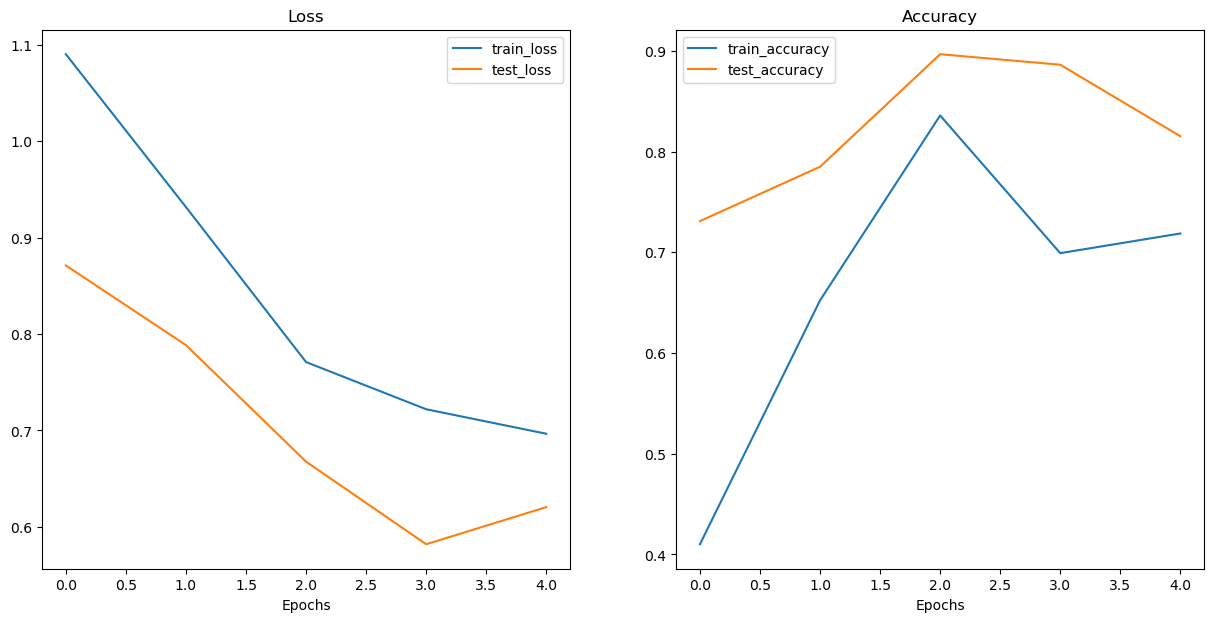

In [29]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of transfer learning. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

In [33]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device="cpu"):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to("cpu"))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

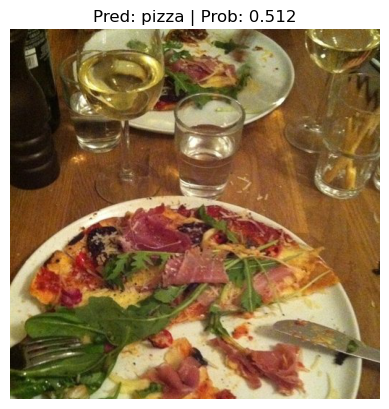

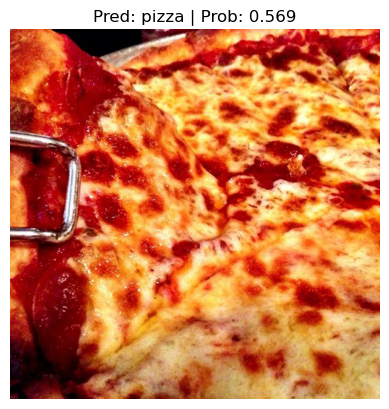

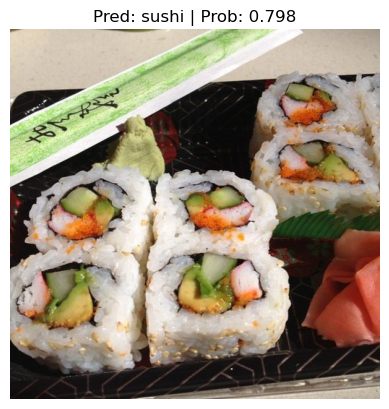

In [34]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

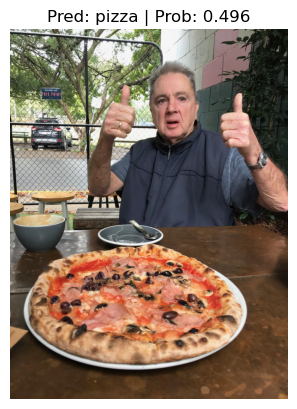

In [35]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)